# 1. Introduction

This series of notebooks show how to use the [scatseisnet](https://scatseisnet.readthedocs.io/en/latest/) package for exploring continuous seismograms with a scattering network. 

Depending on the task at hand, different preprocessing steps might be necessary to prepare the data for the scattering transformation, and use the results for your application. We here present a tutorial workflow that you can adapt to your own data and research questions. The scattering coefficients are well-adapted to data exploration methods such as dimensionality reduction and clustering methods, which we will also explore. 

We investigate different exploration methods which have been presented in Seydoux et al. ([2020](https://www.nature.com/articles/s41467-020-17841-x)), and Steinmann et al. ([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455), [2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL098854), and [2023](https://essopenarchive.org/doi/full/10.22541/essoar.168614505.54607219)), and we hope that these notebooks will inspire your research!

— René Steinmann and Léonard Seydoux, last updated in November 2025.

## Contents

1. [Introduction](1_intro.ipynb) 
1. [Scattering network design](2_design.ipynb)
1. [Scattering transformation](3_transformation.ipynb)
1. [Independent component analysis](4_reduction.ipynb)
1. [Scattering coefficient reconstruction](5_reconstruction.ipynb)
1. [Clustering](6_clustering.ipynb)
1. [Seismogram atlas](7_atlas.ipynb)


## Prerequisites

This tutorial requires the installation of several libraries specified in the pyproject.toml file under the [project.optional-dependencies] tutorials section. To enable the installation of these dependencies, you can use the following command when installing scatseisnet:

```bash
pip install scatseisnet[tutorials]
```

You can also install the required libraries individually using your package manager of choice. The  list of required libraries includes:
- [matplotlib](https://matplotlib.org/stable/users/installing.html)
- [obspy](https://obspy.org/)
- [scikit-learn](https://scikit-learn.org/stable/install.html)
- [umap-learn](https://umap-learn.readthedocs.io/en/latest/installation.html)
- [numpy](https://numpy.org/install/)
- [scipy](https://scipy.org/install/)

In [24]:
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

In [28]:
%config InlineBackend.figure_format = "svg"

## Load seismograms

We choose a one-day-long three-component seismogram from station `SV13` from the temporary _Klyuchevskoy Investigation_ network KISS (code `X9`) that was installed in the Klyuchevskoy volcano group from 2015 to 2016. In our study Steinmann et al. ([2023](https://essopenarchive.org/doi/full/10.22541/essoar.168614505.54607219)), we analyzed the whole recording period from the station SV13. For this tutorial, we narrow down the focus to a single day for demonstration purposes.

We select focus on December 4 in 2015, which marks the onset of tremor activity due to the reactivation of the Klyuchevskoy volcano. We download the data from the [GFZ data center](https://geofon.gfz-potsdam.de/) using ObsPy.

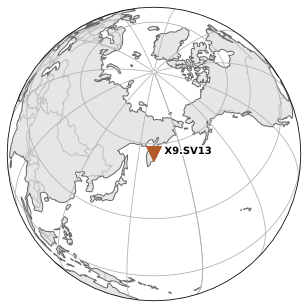

3 Trace(s) in Stream:
X9.SV13..HHZ | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples
X9.SV13..HHN | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples
X9.SV13..HHE | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples


In [ ]:
# Query dictionary
query = {
    "network": "X9",
    "station": "SV13",
    "location": "*",
    "channel": "*",
    "starttime": UTCDateTime("2015-12-04T00:00"),
    "endtime": UTCDateTime("2015-12-05T00:00"),
}

# Collect waveforms and station information from the datacenter
client = Client("GFZ")
stream = client.get_waveforms(**query)
inventory = client.get_stations(**query)

# Show the station loaction map
inventory.plot(projection="ortho")

# Print stream information
print(stream)

## Preprocess seismograms

Before exploring the data, it is helpful to clean and standardize the seismograms. In the next code cell, we apply a minimal yet practical pipeline:

- Merge: combine partially overlapping or gappy segments into continuous traces per channel.
- Detrend (linear): remove linear trends to reduce DC bias and avoid filter edge effects.
- High-pass filter at 1 Hz: suppress long-period drift and microseisms while emphasizing tremor and transient events.

After processing, we quickly inspect the result with a plot and save the stream to MiniSEED for reuse in later notebooks.

Tips for adaptation:
- Tune the corner frequency and filter type to your task and the station’s noise characteristics.
- Consider adding a taper, resampling, or instrument response removal if needed.
- Always visualize after each major step to verify that processing behaves as expected.
- For more options, see ObsPy’s signal processing routines: https://docs.obspy.org/packages/obspy.signal.html

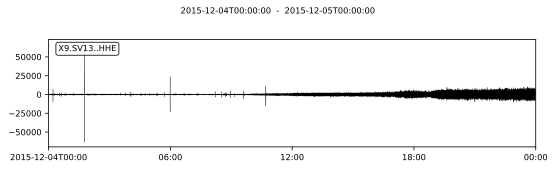

In [32]:
# Preprocess the data: merge, detrend, filter
stream.merge(method=1)
stream.detrend("linear")
stream.filter(type="highpass", freq=1.0)

# Plot one of the seismograms component
stream[0].plot(linewidth=0.5, rasterized=True, method="full", equal_scale=True)

# Save the seismograms to a MiniSEED file
stream.write("../example/stream.mseed", format="MSEED", encoding="FLOAT64")

## Define task

We observe in these seismograms that there is an increase in volcanic tremor activity throughout the day, starting from low levels in the morning and intensifying towards the evening. Additionally, there are several transient seismic events scattered throughout the day.

With scatseisnet we want to **explore this one-day long three-component seismogram and identify clusters related to the tremor and non-tremor activity**. Note that this is only a toy example. The power of scatseisnet and data exploration lies in exploring large continuous time series when manual investigation is not feasible.